#### 1) Distribution setup

Discretize a **Student-t** return distribution (fat tails), calibrated to mean = 0.15 and standard deviation = 0.20, into $2^n$ bins.
- `grid_points`: bin midpoints (representative return value per bin)
- `edges`: bin edges
- `probs`: probability mass per bin (sums to 1)

Because we truncate to $\pm k\sigma$ and renormalize, this introduces **discretization/modeling error** (separate from IQAE/MC estimation error).


Meta: {'dist': 'student_t', 'mu': 0.15, 'sigma_target': 0.2, 'df': 5, 'scale': 0.15491933384829668, 'n_qubits': 7, 'N': 128, 'k_sigmas': 6.0, 'r_min': -1.0500000000000003, 'r_max': 1.35, 'bin_width': 0.018750000000000003, 'trunc_mass': 0.9994267548579605}
Grid size: 128 bins (n_qubits=7)
Truncation range: [-1.050, 1.350]
Truncated mass before renorm: 0.999427


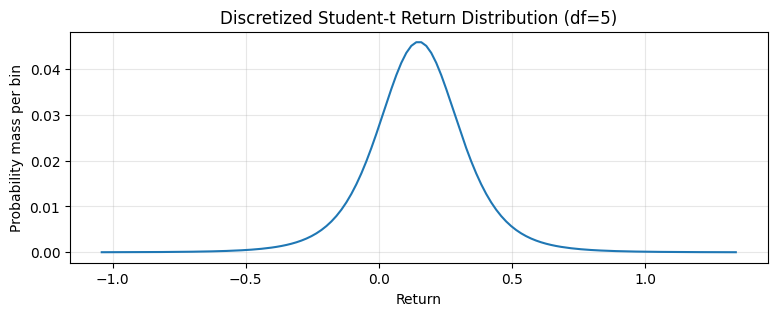

In [7]:
# Discretize a Student-t return distribution into 2^n bins (fat tails)

import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t as student_t
from scipy.stats import norm  # optional, for comparison
from classiq import *
from classiq.applications.iqae.iqae import IQAE

def build_student_t_return_grid_probs(mu=0.15, sigma=0.20, df=5, n_qubits=7, k_sigmas=6.0):
    """Discretize a Student-t distribution into 2^n_qubits bins over [mu-kσ, mu+kσ].

    We use a Student-t with degrees of freedom `df`, shifted by `mu` and scaled so that
    its *standard deviation* matches `sigma` (requires df>2).

    The distribution is then truncated to the finite interval [r_min, r_max] and
    renormalized (this introduces modeling/discretization error).
    """
    if df <= 2:
        raise ValueError("df must be > 2 so the Student-t variance is finite (and can match sigma).")

    N = 2 ** n_qubits

    # For Student-t(df), Var = df/(df-2) (for df>2).
    # Choose scale so that std matches sigma.
    scale = sigma / np.sqrt(df / (df - 2))

    r_min = mu - k_sigmas * sigma
    r_max = mu + k_sigmas * sigma

    edges = np.linspace(r_min, r_max, N + 1)
    grid_centers = 0.5 * (edges[:-1] + edges[1:])

    cdf = student_t.cdf(edges, df=df, loc=mu, scale=scale)
    probs = np.diff(cdf)

    # numerical safety + renormalize (this makes the distribution truncated to [r_min, r_max])
    probs = np.maximum(probs, 0.0)
    probs = probs / probs.sum()

    meta = {
        "dist": "student_t",
        "mu": mu,
        "sigma_target": sigma,
        "df": df,
        "scale": float(scale),
        "n_qubits": n_qubits,
        "N": N,
        "k_sigmas": k_sigmas,
        "r_min": float(r_min),
        "r_max": float(r_max),
        "bin_width": float((r_max - r_min) / N),
        "trunc_mass": float(cdf[-1] - cdf[0]),
    }

    return grid_centers, probs, edges, meta


# Parameters (edit to explore sensitivity later)
MU = 0.15
SIGMA = 0.20
DF = 5          # smaller df => fatter tails (try 3, 5, 10, 30)
NUM_QUBITS = 7
K_SIGMAS = 6.0  # widen truncation window for fat tails

grid_points, probs, edges, meta = build_student_t_return_grid_probs(
    mu=MU, sigma=SIGMA, df=DF, n_qubits=NUM_QUBITS, k_sigmas=K_SIGMAS
)

print("Meta:", meta)
print(f"Grid size: {len(probs)} bins (n_qubits={NUM_QUBITS})")
print(f"Truncation range: [{meta['r_min']:.3f}, {meta['r_max']:.3f}]")
print(f"Truncated mass before renorm: {meta['trunc_mass']:.6f}")

# Visualize the discretized distribution
plt.figure(figsize=(9,3))
plt.plot(grid_points, probs)
plt.title(f"Discretized Student-t Return Distribution (df={DF})")
plt.xlabel("Return")
plt.ylabel("Probability mass per bin")
plt.grid(True, alpha=0.3)
plt.show()


#### 2) VaR definition and ground-truth values

For a left-tail VaR at confidence level **(1-α)**, we use α as the tail probability (e.g., α=0.05 for 95% VaR):

- Tail event: **Return ≤ threshold**
- Tail probability: **P(Return ≤ threshold) = α**
- VaR (return threshold): **quantile at level α**

We compute:
- `VaR_cont`: continuous **Student-t** quantile (untruncated model)
- `VaR_disc`: exact VaR under the discretized/truncated distribution (`probs`) — this is what the quantum circuit actually encodes


In [2]:
ALPHA = 0.05  # 5% left tail -> 95% VaR confidence level (returns)

def var_continuous_student_t(alpha, mu=MU, sigma=SIGMA, df=DF):
    # match sigma via the same scale used in discretization
    scale = sigma / np.sqrt(df / (df - 2))
    return student_t.ppf(alpha, df=df, loc=mu, scale=scale)

def cdf_discrete_at_index(index, probs):
    return float(np.sum(probs[:index]))

def var_discrete_from_probs(alpha, grid_points, probs):
    """Return the smallest index i such that discrete CDF(i) >= alpha."""
    cdf = np.cumsum(probs)
    idx = int(np.searchsorted(cdf, alpha, side='left'))
    idx = np.clip(idx, 0, len(grid_points)-1)
    return idx, float(grid_points[idx])

VaR_cont = var_continuous_student_t(ALPHA, mu=MU, sigma=SIGMA, df=DF)
idx_disc, VaR_disc = var_discrete_from_probs(ALPHA, grid_points, probs)

print(f"ALPHA (tail prob): {ALPHA}")
print(f"Continuous Student-t VaR (untruncated): {VaR_cont:.6f}   (df={DF})")
print(f"Discrete/Truncated VaR (encoded in probs): index={idx_disc}, VaR_disc={VaR_disc:.6f}")
print(f"Discrete CDF at VaR_disc index: {cdf_discrete_at_index(idx_disc, probs):.6f}  (should be ~alpha)")
print(f"Modeling/Discretization error |VaR_disc - VaR_cont| = {abs(VaR_disc - VaR_cont):.6e}")


ALPHA (tail prob): 0.05
Continuous Student-t VaR (untruncated): -0.162170   (df=5)
Discrete/Truncated VaR (encoded in probs): index=47, VaR_disc=-0.159375
Discrete CDF at VaR_disc index: 0.047106  (should be ~alpha)
Modeling/Discretization error |VaR_disc - VaR_cont| = 2.794952e-03


#### 3) Quantum encoding, threshold oracle, and IQAE tail probability estimation

We encode the **same discretized Student-t** distribution (`probs`) as quantum amplitudes, then use a threshold oracle that marks tail events (left tail: `return ≤ threshold`).
IQAE estimates the tail probability \(p(t)=\Pr(R \le t)\) for a chosen threshold index.


In [3]:
# --- Quantum state preparation and oracle ---
# GLOBAL_INDEX is a mutable threshold used by the oracle.
GLOBAL_INDEX = 0

@qfunc(synthesize_separately=True)
def state_preparation(asset: QArray[QBit], ind: QBit):
    load_distribution(asset=asset)
    payoff(asset=asset, ind=ind)

@qfunc
def load_distribution(asset: QNum):
    inplace_prepare_state(probs, bound=0, target=asset)

@qperm
def payoff(asset: Const[QNum], ind: QBit):
    # Tail event: asset index < GLOBAL_INDEX  (left tail)
    ind ^= asset < GLOBAL_INDEX

def get_iqae_query_count(iqae_res):
    """Try to extract oracle/query counts from the result object (SDK-dependent)."""
    # common names used across libraries
    for name in [
        'num_oracle_queries', 'oracle_queries', 'n_oracle_queries',
        'num_queries', 'queries', 'query_count',
        'num_grover_calls', 'grover_calls', 'num_iterations',
        'shots', 'num_shots'
    ]:
        if hasattr(iqae_res, name):
            try:
                return int(getattr(iqae_res, name))
            except Exception:
                pass
    return None

def iqae_tail_prob(threshold_index, epsilon=0.05, alpha_ci=0.01):
    """Estimate tail probability P(asset < threshold_index) using IQAE."""
    global GLOBAL_INDEX
    GLOBAL_INDEX = int(threshold_index)

    iqae = IQAE(
        state_prep_op=state_preparation,
        problem_vars_size=NUM_QUBITS,
        constraints=Constraints(max_width=28),
        preferences=Preferences(machine_precision=NUM_QUBITS),
    )
    _ = iqae.get_qprog()  # ensures synthesis
    res = iqae.run(epsilon=float(epsilon), alpha=float(alpha_ci))

    est = float(res.estimation)
    ci = tuple(res.confidence_interval) if hasattr(res, 'confidence_interval') else None
    qcount = get_iqae_query_count(res)

    return est, ci, qcount

# Quick sanity check at the discrete VaR index:
p_true = cdf_discrete_at_index(idx_disc, probs)
p_hat, ci, qcount = iqae_tail_prob(idx_disc, epsilon=0.05, alpha_ci=0.01)
print(f"Tail prob at idx={idx_disc}: true={p_true:.4f}, IQAE={p_hat:.4f}, CI={ci}, queries={qcount}")

Tail prob at idx=47: true=0.0471, IQAE=0.0452, CI=(0.0413049912135177, 0.049110388400353804), queries=None


#### 4) Quantum VaR via bisection search

We search for the smallest index `i` such that the estimated tail probability satisfies:

- `P(Return ≤ threshold_i) ≈ α`

We use IQAE to estimate the tail probability at each candidate threshold.

In [4]:
def quantum_var_bisection(alpha, probs, epsilon=0.05, alpha_ci=0.01, max_iters=25):
    """Find discrete VaR index using bisection + IQAE tail probability estimates."""
    lo, hi = 0, len(probs) - 1
    best = hi

    for it in range(max_iters):
        mid = (lo + hi) // 2
        p_hat, ci, qcount = iqae_tail_prob(mid, epsilon=epsilon, alpha_ci=alpha_ci)

        # Bisection logic: want CDF(mid) >= alpha
        if p_hat >= alpha:
            best = mid
            hi = mid - 1
        else:
            lo = mid + 1

        if lo > hi:
            break

    return best, float(grid_points[best])

# Run quantum VaR
EPSILON_IQAE = 0.05
ALPHA_CI = 0.01

idx_q, VaR_q = quantum_var_bisection(ALPHA, probs, epsilon=EPSILON_IQAE, alpha_ci=ALPHA_CI, max_iters=25)

print(f"Quantum VaR (discrete index): {idx_q}")
print(f"Quantum VaR (return value):   {VaR_q:.6f}")
print(f"Discrete truth VaR_disc:      {VaR_disc:.6f}")
print(f"Estimation error |VaR_q - VaR_disc| = {abs(VaR_q - VaR_disc):.6e}")

Quantum VaR (discrete index): 48
Quantum VaR (return value):   -0.140625
Discrete truth VaR_disc:      -0.159375
Estimation error |VaR_q - VaR_disc| = 1.875000e-02


IQAE prob N~    10: est=0.0471, |err|=9.1327e-04, eps=0.0785
IQAE prob N~    25: est=0.0474, |err|=3.9525e-04, eps=0.0314
IQAE prob N~    50: est=0.0475, |err|=9.9740e-04, eps=0.0157
IQAE prob N~   100: est=0.0471, |err|=6.2834e-05, eps=0.0079
IQAE prob N~   250: est=0.0471, |err|=5.7461e-05, eps=0.0031

Scaling summary (probability estimation):
  IQAE slope = -0.932 (expected -1.0)  R^2=0.680


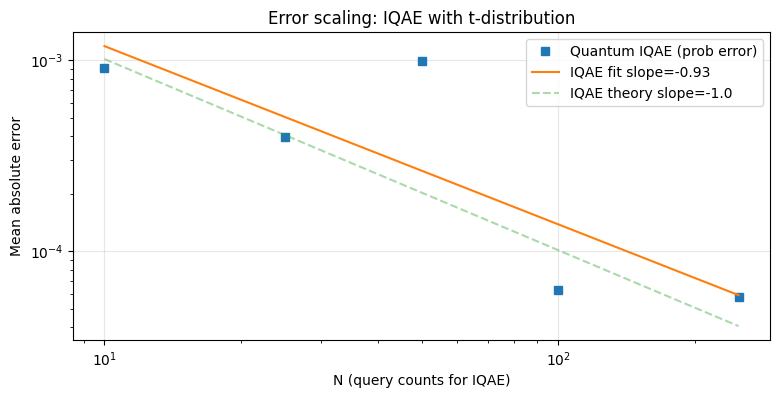

In [ ]:
# --- Probability estimation target (fixed threshold) ---
TEST_INDEX = idx_disc
TRUE_CDF = float(np.sum(probs[:TEST_INDEX]))

def run_classical_prob_convergence(probs, threshold_index, true_value, sample_sizes, n_trials=20):
    out = {'N': list(sample_sizes), 'mean_errors': [], 'std_errors': [], 'mean_estimates': []}
    for N in sample_sizes:
        errs, ests = [], []
        for t in range(n_trials):
            est = classical_monte_carlo_cdf(probs, threshold_index, N, seed=1000*t + N)
            ests.append(est)
            errs.append(abs(est - true_value))
        out['mean_errors'].append(float(np.mean(errs)))
        out['std_errors'].append(float(np.std(errs)))
        out['mean_estimates'].append(float(np.mean(ests)))
        print(f"MC prob  N={N:6d}: est={np.mean(ests):.4f}, |err|={np.mean(errs):.4e}")
    return out

def run_iqae_prob_convergence(query_budgets, true_value, n_trials=5, alpha_ci=0.01):
    out = {'N': list(query_budgets), 'epsilons': [], 'mean_errors': [], 'std_errors': [], 'mean_estimates': []}
    for N in query_budgets:
        eps = np.pi / (4 * N)
        eps = float(np.clip(eps, 1e-4, 0.5))
        errs, ests = [], []
        for t in range(n_trials):
            est, ci, qcount = iqae_tail_prob(TEST_INDEX, epsilon=eps, alpha_ci=alpha_ci)
            ests.append(est)
            errs.append(abs(est - true_value))
        out['epsilons'].append(eps)
        out['mean_errors'].append(float(np.mean(errs)))
        out['std_errors'].append(float(np.std(errs)))
        out['mean_estimates'].append(float(np.mean(ests)))
        print(f"IQAE prob N~{N:6d}: est={np.mean(ests):.4f}, |err|={np.mean(errs):.4e}, eps={eps:.4f}")
    return out

N_values = [10, 25, 50, 100, 250, 500, 1000]

quantum_prob   = run_iqae_prob_convergence(N_values, TRUE_CDF, n_trials=5, alpha_ci=0.01)

# Fit log-log slope: log(err) = slope*log(N) + intercept
def fit_loglog(N, y):
    x = np.log10(np.asarray(N))
    yy = np.log10(np.asarray(y))
    slope, intercept, r, p, stderr = stats.linregress(x, yy)
    return slope, intercept, r*r, stderr

q_slope_p,  q_int_p,  q_r2_p,  _ = fit_loglog(quantum_prob['N'], quantum_prob['mean_errors'])

print("\nScaling summary (probability estimation):")
print(f"  IQAE slope = {q_slope_p:.3f} (expected -1.0)  R^2={q_r2_p:.3f}")

# Plot
plt.figure(figsize=(9,4))
plt.loglog(quantum_prob['N'], quantum_prob['mean_errors'], 's', label='Quantum IQAE (prob error)')
N_fit = np.array([min(N_values), max(N_values)])
plt.loglog(N_fit, 10**q_int_p*(N_fit**q_slope_p), '-', label=f'IQAE fit slope={q_slope_p:.2f}')
plt.loglog(N_fit, 10**q_int_p*(N_fit**(-1.0)), '--', alpha=0.4, label='IQAE theory slope=-1.0')
plt.xlabel('N (query counts for IQAE)')
plt.ylabel('Mean absolute error')
plt.title('Error scaling: IQAE with t-distribution')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()
